# <font color='blue'><center>Forecasting stock price using Artificial Neural Network and Genetic Algorithm</center></font>

## Capstone Project

**Objective** - Forecasting stock prices is crucial in investment decision-making. Traditional statistics and artificial intelligence techniques are widely used to study price prediction. Stock prices exhibit non-linear dynamics, making it difficult to forecast through a single model. Therefore, there is a need to develop hybrid models to make more informed decisions. The main objective of this study is to forecast stock prices using Artificial Neural Network (ANN) combined with heuristic methods such as Genetic Algorithm (GA). We used technical indicators as neural network input features. In this research, the statistical population comprises three US market indices S&P500, DOW30, and NASDAQ100 for forecasting. Model performance is evaluated using Mean Absolute Percentage Error (MAPE) loss function.

**Data Source:** https://finance.yahoo.com/

In [2]:
# import the required libraries

import re
import os
import random
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

import pygad
import pygad.nn
import pygad.kerasga

In [2]:
# Index symbols
#Dow Jones Industrial Average - DJI
#S&P 500 - GSPC
#NASDAQ Composite - IXIC

sdate = "2015-01-01"
edate = "2023-12-31"
symbols = ['^DJI','^GSPC','^IXIC']

# Download data from yahoo finance
dfs = []
for symbol in symbols:
    yfdata = yf.download(symbol, start=sdate, end=edate)
    yfdata['Index'] = symbol
    dfs.append(yfdata)

# Concatenate the individual DataFrames into one
idx_data = pd.concat(dfs)
idx_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Index
Date,,,,,,,
2015-01-02,17823.070312,17951.779297,17731.300781,17832.990234,17832.990234,76270000,^DJI
2015-01-05,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,116160000,^DJI
2015-01-06,17504.179688,17581.050781,17262.369141,17371.640625,17371.640625,101870000,^DJI
2015-01-07,17374.779297,17597.080078,17374.779297,17584.519531,17584.519531,91030000,^DJI
2015-01-08,17591.970703,17916.039062,17591.970703,17907.869141,17907.869141,114890000,^DJI


In [3]:
#clean the Index name in the Index column
idx_data['Index'] = idx_data['Index'].apply(lambda x: re.sub("\^","",x) )
idx_data['Index'].value_counts()

Index
DJI     2264
GSPC    2264
IXIC    2264
Name: count, dtype: int64

### Check for data completeness i.e. zero datapoints or NA datapoints

In [4]:
(idx_data == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

Check for NA or Null datapoints

In [5]:
idx_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

In [6]:
# size
row = idx_data.shape[0]
print(row)

6792


**Observations** - There are no invalid datapoints in our dataset. We have checked for if any datapoint is 0 or Null. Now, we plot the Closing price timeseries for each index.

In [7]:
symbols1 = [re.sub("\^","", x ) for x in symbols]
symbols1

['DJI', 'GSPC', 'IXIC']

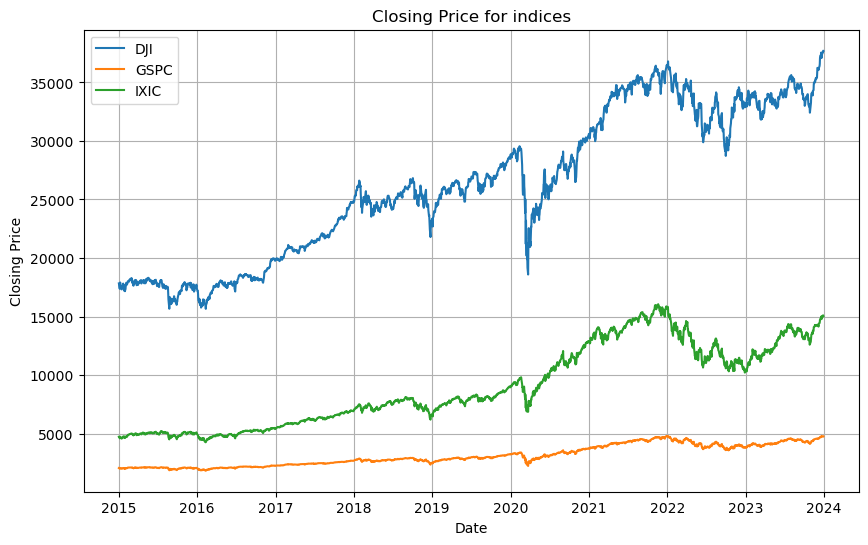

In [8]:
# Plot the closing price for each index
plt.figure(figsize=(10, 6))
for symbol in symbols1:
    ticker_data = idx_data[idx_data['Index'] == symbol]
    plt.plot(ticker_data.index, ticker_data['Close'], label=symbol)

plt.title('Closing Price for indices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

**Observation** - From the above figure, it can be observed that stock prices are highly non-linear in nature. Hence, they cannot be easily forecasted by any time-series based or simple linear regression models. We need more dynamic and complex model that can identify the hidden patterns in the dataset and better fit the non-linearity. For this study, we are analysing artificial neural networks (ANN) model to fit this dataset. Since, hybrid model performs better in modelling non-linear and complex relations. In addition, we will also use Genetic Algorithm (GA) model to improve the performance of simple ANN model.

### Derive technical indicators

Technical analysis is a tool to forecast direction of security prices through past prices and volume data. Technical analysts say that the market price reflects all information. So, they look at security’s historical trading pattern and forecast the direction rather than company fundamentals and news events. Security prices move in trends i.e. either price can go up, down or move sideways. Technical analyst believes that history tend to repeat itself and past trading patterns might appear again. 

There are various technical indicators developed to identify Trend, Momentum, Volume, Volatility and other combinations. In this study, we have chosen most important and commonly used technical indicators among traders and portfolio managers. The technical indicators are presented in the below table.



    1.	Open	          The open price
    2.	Low               The lowest price
    3.	High	          The highest price
    4.	Close             The closing price
    5.	Volume            Number of shares traded
    6.	SMA-5             5-days simple moving average
    7.	SMA-10	        10-days simple moving average
    8.	EMA-5             5-days exponential moving average
    9.	MP	            Mean Price
    10.   TP	            Typical Price
    11.   RSI               Relative Strength Index
    12.   Williams %R       Williams Percent Range
    13.   Upper Band	    Upper Bolinger Band
    14.   Lower Band	    Lower Bolinger Band
    15.   ROC	           Rate of Change
    16.   ATR	           Average True Range	
    17.   ADL	           Accumulation distribution Line
    18.   MFI	           Money Flow Index
    19.   CCI	           Commodity Channel Index

In [9]:
# Compute technical indicators

# calculate simple moving avergae
# Input - Close prices, Window: lookback period
# Output - Returns Simple moving average
def SMA(data, window):
    cname = 'SMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    return data

# calculate exponential moving avergae
# Input - Close prices, Window: lookback period
# Output - Returns exponential moving average
def EMA(data, window):
    def cal_EMA(closepx, window):
        k = 2 / (window+1)
        nrow = closepx.size
        ema = [np.nan] * nrow
        ema[window - 1] = np.mean(closepx[:window])
        for i in range(window, nrow):
            ema[i] = (closepx.iloc[i] * k) + (ema[i - 1] * (1 - k))
        return ema
    cname = 'EMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].transform(lambda x: cal_EMA(x,window))
    return data

# calculate the Bollinger Bands
# Input - Close prices, Window: lookback period
# Output - Returns Bollinger Bands using Meand and SD
def Bollinger_bands(data, window):
    data["MA"] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    data["SD"] = data.groupby('Index')['Close'].rolling(window).std().reset_index(0, drop=True)
    data['UpperBand'] = data["MA"] + (2 * data["SD"] ) 
    data['LowerBand'] = data["MA"] - (2 * data["SD"] )
    data = data.drop(['MA', 'SD'], axis=1)
    return data

# calculate rate of change
# Input - Close prices, Window: lookback period
# Output - Returns the rate of change in closing price
def ROC(data, window):
    def cal_ROC(closepx, window):
        roc = closepx.pct_change(periods=window)
        return roc
    data['ROC'] = data.groupby('Index')['Close'].transform(lambda x: cal_ROC(x,window))
    return data

# calculate RSI values
# Input - Close prices, Window: lookback period
# Output - Relative strength indicator: measures the speed and change of price movements.
def RSI(data, window):
    def cal_RSI(closepx,window):
        diff = closepx.diff(1)
        up_direction = diff.where(diff > 0, 0.0)
        down_direction = -diff.where(diff < 0, 0.0)
        min_periods = window
        emaup = up_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        emadn = down_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        relative_strength = emaup / emadn
        rsi = pd.Series(
            np.where(emadn == 0, 100, 100 - (100 / (1 + relative_strength))),
            index=closepx.index,
        )
        return rsi
    data['RSI'] = data.groupby('Index')['Close'].transform(lambda x: cal_RSI(x,window))
    return data


#Below indicators used more than one parameter in addition to Close. They also use High and Low prices.
# Volume based indicator also use Volume as their input

# Input - High, Low, Close prices, Window: lookback period
# Output - Williams %R reflects the level of the close relative to the highest high for the look-back period.
def williamsR(df,window):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]
    highest_high = high.rolling( window).max()  # highest high over the window
    lowest_low =  low.rolling(window  ).min()  # lowest low over the window
    wr = -100 * (highest_high - close) / (highest_high - lowest_low)
    return wr

# Input - High, Low, Close prices, Window: lookback period
# Output - ATR measures volatility, taking into account any gaps in the price movement.
def ATR(df, window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    pclose = df['Close'].shift(1)
    tr1 =    high - low
    tr2 = (high - pclose).abs()
    tr3 = (low - pclose).abs()
    true_range = pd.DataFrame(data={"tr1": tr1, "tr2": tr2, "tr3": tr3}).max(axis=1)
    atr = np.full(len(close), np.nan)
    atr[window - 1] = true_range[0 : window].mean()
    for i in range(window, len(atr)):
        atr[i] = (atr[i - 1] * (window - 1) + true_range.iloc[i]) / float( window )
    #atr = pd.Series(data=atr)
    return atr

# Input - High, Low, Close prices, Volume. Window: lookback period
# Output - ADI identify divergences between the stock price and the volume flow.
def ADI(df):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    clv = ((close - low) - (high - close)) / ( high - low)
    clv = clv.fillna(0.0)  # float division by zero
    adi = clv * volume
    adi = adi.cumsum()
    return adi

# Input - High, Low, Close prices, Volume. Window: lookback period
# Output - MFI tells traders if there is a higher buying or selling pressure in the market
def MFI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    TP = (high + low + close) / 3.0
    up_down = np.where( TP > TP.shift(1), 1, np.where(TP < TP.shift(1), -1, 0),)
    mfr = TP * volume * up_down

    n_positive_mf = mfr.rolling(window).apply(lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True )
    n_negative_mf = abs(mfr.rolling(window).apply(lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True))
    
    mfi = n_positive_mf / n_negative_mf
    mfi = 100 - (100 / (1 + mfi))
    
    return mfi

# Input - High, Low, Close prices. Window: lookback period
# Output - CCI measures the current price level relative to an average price level
def CCI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    TP = (high + low + close) / 3.0
    constant = 0.015
    def _mad(x):
        return np.mean(np.abs(x - np.mean(x)))
    
    cci = ( TP - TP.rolling(window).mean() ) / (
            constant  * TP.rolling(window).apply( _mad, True  )
    )
    return cci

In [10]:
#calculate technical indicator for each index

idx_data["MP"] =  (idx_data["High"] + idx_data["Low"]  ) / 2.0
idx_data["TP"] = (idx_data["High"] + idx_data["Low"] + idx_data["Close"]  ) / 3.0
idx_data = SMA(idx_data,5)
idx_data = SMA(idx_data,10)
idx_data = EMA(idx_data,5)
idx_data = RSI(idx_data,20)
idx_data = Bollinger_bands(idx_data,20)
idx_data = ROC(idx_data,1)

In [11]:
# Now, separate each index data from the combined data 
dow    = idx_data[idx_data["Index"] == "DJI"]
sp5    = idx_data[idx_data["Index"] == "GSPC"]
nasdaq = idx_data[idx_data["Index"] == "IXIC"]

with pd.option_context('mode.chained_assignment', None):
    
    #calculate technical indicators where more than one price parameter [Close] is used.
    dow["WR"] = williamsR(dow,14)
    dow["ATR"] = ATR(dow,14)
    dow["ADI"] = ADI(dow)
    dow["MFI"] = MFI(dow,14)
    dow["CCI"] = CCI(dow,20)

    sp5["WR"] = williamsR(sp5,14)
    sp5["ATR"] = ATR(sp5,14)
    sp5["ADI"] = ADI(sp5)
    sp5["MFI"] = MFI(sp5,14)
    sp5["CCI"] = CCI(sp5,20)

    nasdaq["WR"] = williamsR(nasdaq,14)
    nasdaq["ATR"] = ATR(nasdaq,14)
    nasdaq["ADI"] = ADI(nasdaq)
    nasdaq["MFI"] = MFI(nasdaq,14)
    nasdaq["CCI"] = CCI(nasdaq,20)
    
    # Target price is next day closing price
    dow['Targetprice']    = dow['Close'].shift(-1)
    sp5['Targetprice']    = sp5['Close'].shift(-1)
    nasdaq['Targetprice'] = nasdaq['Close'].shift(-1)

In [12]:
dow.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Index', 'MP',
       'TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI', 'Targetprice'],
      dtype='object')

In [13]:
# Remove NAN or NA values from the dataframe
with pd.option_context('mode.chained_assignment', None):
    dow.dropna(inplace=True)
    sp5.dropna(inplace=True)
    nasdaq.dropna(inplace=True)

In [14]:
dow.shape

(2244, 22)

In [15]:
dow_vol = "{:.2f}".format(100* np.sqrt(252)* dow['ROC'].std() )
sp5_vol = "{:.2f}".format(100* np.sqrt(252)* sp5['ROC'].std() )
nasdaq_vol = "{:.2f}".format(100*  np.sqrt(252)* nasdaq['ROC'].std() )

In [16]:
print(f"Dow index volatility is: {dow_vol}%")
print(f"S&P500 index volatility is: {sp5_vol}%")
print(f"Nasdaq index volatility is: {nasdaq_vol}%")

Dow index volatility is: 18.10%
S&P500 index volatility is: 18.33%
Nasdaq index volatility is: 21.70%


**Result** - It can be clearly seen that Dow index is least volatile compared to other two indices. Nasdaq index was more volatile during the analysis period.

### Artifical Neural Network (ANN) Training

We will train the ANN model on the Dow index. We have 19 features in the input layer. Output layer consist of 1 Node i.e. predicted closing price. Down index had total 2244 rows. Out of this 80% data is used for training and 20% data is used for out-of-sample testing. Input features are scaled using StandardScaler to bring all the features on a same scale. This results in a dataset with normalized values represented using Z-score.

**ANN Parameters**

    1	Scaling            StandardScaler
    2	Train-test Split   80% Training and 20% Testing
    3	Activation         ReLU (Rectified linear activation)
    4	Optimiser          Adam (Adaptive moment estimation)
    5    Loss function      MAPE (Mean absolute percentage error)
    6    Epochs             400
    7    Batch Size         64

In [17]:
# define ANN model
# Input - Pandas Dataframe
# Output - Returns a trained model
def ANN_model(df):
    
    X = df.drop(['Adj Close','Index','Targetprice'], axis=1)
    y = df['Targetprice']
    #X = dow[['Open', 'High', 'Low', 'Volume','Close','MP','TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
    #       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI']]

    # Scale the input features using MinMax scaling
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    # number of independent predictors
    n_cols = X.shape[1]
    
    # create Sequential model
    tf.keras.backend.clear_session()
    #tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(40, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    
    # fit the model
    epochs = 400
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = 64,verbose=2)
    
    return history, model, X_test, y_test

In [18]:
history_dow,model_dow,X_test_dow,y_test_dow = ANN_model(dow)
history_sp5,model_sp5,X_test_sp5,y_test_sp5 = ANN_model(sp5)
history_nasd,model_nasd,X_test_nasd,y_test_nasd = ANN_model(nasdaq)

(1795, 19) (449, 19) (1795,) (449,)



C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
29/29 - 4s - 132ms/step - loss: 99.9954
Epoch 2/400
29/29 - 0s - 4ms/step - loss: 99.9806
Epoch 3/400
29/29 - 0s - 4ms/step - loss: 99.9317
Epoch 4/400
29/29 - 0s - 4ms/step - loss: 99.7706
Epoch 5/400
29/29 - 0s - 4ms/step - loss: 99.3646
Epoch 6/400
29/29 - 0s - 4ms/step - loss: 98.5503
Epoch 7/400
29/29 - 0s - 3ms/step - loss: 96.9134
Epoch 8/400
29/29 - 0s - 3ms/step - loss: 94.1111
Epoch 9/400
29/29 - 0s - 4ms/step - loss: 90.3944
Epoch 10/400
29/29 - 0s - 4ms/step - loss: 84.6007
Epoch 11/400
29/29 - 0s - 4ms/step - loss: 76.5333
Epoch 12/400
29/29 - 0s - 3ms/step - loss: 64.5236
Epoch 13/400
29/29 - 0s - 4ms/step - loss: 57.4640
Epoch 14/400
29/29 - 0s - 4ms/step - loss: 54.6606
Epoch 15/400
29/29 - 0s - 4ms/step - loss: 52.2530
Epoch 16/400
29/29 - 0s - 3ms/step - loss: 50.0560
Epoch 17/400
29/29 - 0s - 6ms/step - loss: 47.1845
Epoch 18/400
29/29 - 0s - 3ms/step - loss: 44.1433
Epoch 19/400
29/29 - 0s - 3ms/step - loss: 41.4964
Epoch 20/400
29/29 - 0s - 4ms/step - l

29/29 - 0s - 4ms/step - loss: 1.6887
Epoch 163/400
29/29 - 0s - 4ms/step - loss: 1.6664
Epoch 164/400
29/29 - 0s - 4ms/step - loss: 1.6168
Epoch 165/400
29/29 - 0s - 3ms/step - loss: 1.5614
Epoch 166/400
29/29 - 0s - 4ms/step - loss: 1.5494
Epoch 167/400
29/29 - 0s - 4ms/step - loss: 1.5441
Epoch 168/400
29/29 - 0s - 4ms/step - loss: 1.5326
Epoch 169/400
29/29 - 0s - 4ms/step - loss: 1.4813
Epoch 170/400
29/29 - 0s - 4ms/step - loss: 1.4809
Epoch 171/400
29/29 - 0s - 4ms/step - loss: 1.4138
Epoch 172/400
29/29 - 0s - 4ms/step - loss: 1.4593
Epoch 173/400
29/29 - 0s - 3ms/step - loss: 1.4033
Epoch 174/400
29/29 - 0s - 3ms/step - loss: 1.3555
Epoch 175/400
29/29 - 0s - 3ms/step - loss: 1.2924
Epoch 176/400
29/29 - 0s - 3ms/step - loss: 1.2917
Epoch 177/400
29/29 - 0s - 4ms/step - loss: 1.2750
Epoch 178/400
29/29 - 0s - 3ms/step - loss: 1.2618
Epoch 179/400
29/29 - 0s - 4ms/step - loss: 1.3134
Epoch 180/400
29/29 - 0s - 4ms/step - loss: 1.2056
Epoch 181/400
29/29 - 0s - 4ms/step - loss: 1

Epoch 323/400
29/29 - 0s - 4ms/step - loss: 0.7443
Epoch 324/400
29/29 - 0s - 3ms/step - loss: 0.7126
Epoch 325/400
29/29 - 0s - 4ms/step - loss: 0.7231
Epoch 326/400
29/29 - 0s - 3ms/step - loss: 0.7804
Epoch 327/400
29/29 - 0s - 3ms/step - loss: 0.7126
Epoch 328/400
29/29 - 0s - 4ms/step - loss: 0.7303
Epoch 329/400
29/29 - 0s - 3ms/step - loss: 0.7793
Epoch 330/400
29/29 - 0s - 3ms/step - loss: 0.8208
Epoch 331/400
29/29 - 0s - 3ms/step - loss: 0.7495
Epoch 332/400
29/29 - 0s - 4ms/step - loss: 0.7371
Epoch 333/400
29/29 - 0s - 3ms/step - loss: 0.7090
Epoch 334/400
29/29 - 0s - 3ms/step - loss: 0.7061
Epoch 335/400
29/29 - 0s - 5ms/step - loss: 0.7318
Epoch 336/400
29/29 - 0s - 5ms/step - loss: 0.7468
Epoch 337/400
29/29 - 0s - 4ms/step - loss: 0.7240
Epoch 338/400
29/29 - 0s - 4ms/step - loss: 0.7202
Epoch 339/400
29/29 - 0s - 4ms/step - loss: 0.7127
Epoch 340/400
29/29 - 0s - 4ms/step - loss: 0.7201
Epoch 341/400
29/29 - 0s - 4ms/step - loss: 0.7845
Epoch 342/400
29/29 - 0s - 3ms/

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 3s - 86ms/step - loss: 99.9668
Epoch 2/400
29/29 - 0s - 5ms/step - loss: 99.8353
Epoch 3/400
29/29 - 0s - 4ms/step - loss: 99.4387
Epoch 4/400
29/29 - 0s - 4ms/step - loss: 98.3814
Epoch 5/400
29/29 - 0s - 4ms/step - loss: 95.3692
Epoch 6/400
29/29 - 0s - 4ms/step - loss: 89.0200
Epoch 7/400
29/29 - 0s - 4ms/step - loss: 75.7029
Epoch 8/400
29/29 - 0s - 4ms/step - loss: 57.1865
Epoch 9/400
29/29 - 0s - 3ms/step - loss: 52.5698
Epoch 10/400
29/29 - 0s - 4ms/step - loss: 49.5157
Epoch 11/400
29/29 - 0s - 4ms/step - loss: 47.3046
Epoch 12/400
29/29 - 0s - 4ms/step - loss: 42.9489
Epoch 13/400
29/29 - 0s - 4ms/step - loss: 39.1049
Epoch 14/400
29/29 - 0s - 3ms/step - loss: 35.1806
Epoch 15/400
29/29 - 0s - 4ms/step - loss: 33.7257
Epoch 16/400
29/29 - 0s - 4ms/step - loss: 33.8196
Epoch 17/400
29/29 - 0s - 3ms/step - loss: 33.3682
Epoch 18/400
29/29 - 0s - 3ms/step - loss: 31.7812
Epoch 19/400
29/29 - 0s - 3ms/step - loss: 31.5228
Epoch 20/400
29/29 - 0s - 3ms/step - loss: 30.3751


29/29 - 0s - 3ms/step - loss: 0.8102
Epoch 164/400
29/29 - 0s - 3ms/step - loss: 0.8089
Epoch 165/400
29/29 - 0s - 2ms/step - loss: 0.7930
Epoch 166/400
29/29 - 0s - 2ms/step - loss: 0.7818
Epoch 167/400
29/29 - 0s - 2ms/step - loss: 0.8251
Epoch 168/400
29/29 - 0s - 3ms/step - loss: 0.8629
Epoch 169/400
29/29 - 0s - 2ms/step - loss: 0.8086
Epoch 170/400
29/29 - 0s - 2ms/step - loss: 0.7867
Epoch 171/400
29/29 - 0s - 3ms/step - loss: 0.7943
Epoch 172/400
29/29 - 0s - 2ms/step - loss: 0.8478
Epoch 173/400
29/29 - 0s - 2ms/step - loss: 0.8161
Epoch 174/400
29/29 - 0s - 2ms/step - loss: 0.8312
Epoch 175/400
29/29 - 0s - 3ms/step - loss: 0.7774
Epoch 176/400
29/29 - 0s - 2ms/step - loss: 0.8408
Epoch 177/400
29/29 - 0s - 2ms/step - loss: 0.7865
Epoch 178/400
29/29 - 0s - 2ms/step - loss: 0.7674
Epoch 179/400
29/29 - 0s - 2ms/step - loss: 0.7722
Epoch 180/400
29/29 - 0s - 2ms/step - loss: 0.7747
Epoch 181/400
29/29 - 0s - 2ms/step - loss: 0.7903
Epoch 182/400
29/29 - 0s - 2ms/step - loss: 0

Epoch 324/400
29/29 - 0s - 2ms/step - loss: 0.7126
Epoch 325/400
29/29 - 0s - 2ms/step - loss: 0.7208
Epoch 326/400
29/29 - 0s - 2ms/step - loss: 0.7278
Epoch 327/400
29/29 - 0s - 2ms/step - loss: 0.6925
Epoch 328/400
29/29 - 0s - 3ms/step - loss: 0.7586
Epoch 329/400
29/29 - 0s - 2ms/step - loss: 0.6970
Epoch 330/400
29/29 - 0s - 3ms/step - loss: 0.7099
Epoch 331/400
29/29 - 0s - 2ms/step - loss: 0.7826
Epoch 332/400
29/29 - 0s - 3ms/step - loss: 0.7191
Epoch 333/400
29/29 - 0s - 2ms/step - loss: 0.7736
Epoch 334/400
29/29 - 0s - 3ms/step - loss: 0.7105
Epoch 335/400
29/29 - 0s - 2ms/step - loss: 0.7452
Epoch 336/400
29/29 - 0s - 3ms/step - loss: 0.7371
Epoch 337/400
29/29 - 0s - 2ms/step - loss: 0.7296
Epoch 338/400
29/29 - 0s - 3ms/step - loss: 0.7266
Epoch 339/400
29/29 - 0s - 2ms/step - loss: 0.7213
Epoch 340/400
29/29 - 0s - 3ms/step - loss: 0.7140
Epoch 341/400
29/29 - 0s - 3ms/step - loss: 0.7469
Epoch 342/400
29/29 - 0s - 3ms/step - loss: 0.8217
Epoch 343/400
29/29 - 0s - 3ms/

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 1s - 52ms/step - loss: 99.9667
Epoch 2/400
29/29 - 0s - 4ms/step - loss: 99.8653
Epoch 3/400
29/29 - 0s - 4ms/step - loss: 99.5491
Epoch 4/400
29/29 - 0s - 3ms/step - loss: 98.7504
Epoch 5/400
29/29 - 0s - 3ms/step - loss: 96.9053
Epoch 6/400
29/29 - 0s - 2ms/step - loss: 93.4378
Epoch 7/400
29/29 - 0s - 3ms/step - loss: 86.5094
Epoch 8/400
29/29 - 0s - 3ms/step - loss: 74.9601
Epoch 9/400
29/29 - 0s - 3ms/step - loss: 59.0591
Epoch 10/400
29/29 - 0s - 3ms/step - loss: 53.9035
Epoch 11/400
29/29 - 0s - 3ms/step - loss: 54.1527
Epoch 12/400
29/29 - 0s - 3ms/step - loss: 52.9138
Epoch 13/400
29/29 - 0s - 3ms/step - loss: 52.4202
Epoch 14/400
29/29 - 0s - 2ms/step - loss: 50.0241
Epoch 15/400
29/29 - 0s - 3ms/step - loss: 50.5838
Epoch 16/400
29/29 - 0s - 2ms/step - loss: 49.4273
Epoch 17/400
29/29 - 0s - 2ms/step - loss: 47.7056
Epoch 18/400
29/29 - 0s - 2ms/step - loss: 45.8343
Epoch 19/400
29/29 - 0s - 2ms/step - loss: 43.3177
Epoch 20/400
29/29 - 0s - 3ms/step - loss: 40.9701


Epoch 163/400
29/29 - 0s - 3ms/step - loss: 1.0278
Epoch 164/400
29/29 - 0s - 2ms/step - loss: 1.0278
Epoch 165/400
29/29 - 0s - 2ms/step - loss: 0.9983
Epoch 166/400
29/29 - 0s - 3ms/step - loss: 1.0308
Epoch 167/400
29/29 - 0s - 2ms/step - loss: 1.0541
Epoch 168/400
29/29 - 0s - 2ms/step - loss: 1.0454
Epoch 169/400
29/29 - 0s - 2ms/step - loss: 1.0077
Epoch 170/400
29/29 - 0s - 3ms/step - loss: 1.0478
Epoch 171/400
29/29 - 0s - 2ms/step - loss: 1.0003
Epoch 172/400
29/29 - 0s - 2ms/step - loss: 1.0769
Epoch 173/400
29/29 - 0s - 3ms/step - loss: 0.9987
Epoch 174/400
29/29 - 0s - 2ms/step - loss: 1.1663
Epoch 175/400
29/29 - 0s - 2ms/step - loss: 0.9860
Epoch 176/400
29/29 - 0s - 2ms/step - loss: 0.9949
Epoch 177/400
29/29 - 0s - 3ms/step - loss: 1.0485
Epoch 178/400
29/29 - 0s - 2ms/step - loss: 0.9796
Epoch 179/400
29/29 - 0s - 2ms/step - loss: 0.9825
Epoch 180/400
29/29 - 0s - 3ms/step - loss: 0.9755
Epoch 181/400
29/29 - 0s - 3ms/step - loss: 1.0525
Epoch 182/400
29/29 - 0s - 3ms/

Epoch 324/400
29/29 - 0s - 3ms/step - loss: 0.9412
Epoch 325/400
29/29 - 0s - 3ms/step - loss: 0.9175
Epoch 326/400
29/29 - 0s - 2ms/step - loss: 0.8868
Epoch 327/400
29/29 - 0s - 2ms/step - loss: 0.9300
Epoch 328/400
29/29 - 0s - 3ms/step - loss: 0.9485
Epoch 329/400
29/29 - 0s - 3ms/step - loss: 0.9093
Epoch 330/400
29/29 - 0s - 2ms/step - loss: 0.9093
Epoch 331/400
29/29 - 0s - 3ms/step - loss: 0.8876
Epoch 332/400
29/29 - 0s - 2ms/step - loss: 0.9558
Epoch 333/400
29/29 - 0s - 2ms/step - loss: 0.9591
Epoch 334/400
29/29 - 0s - 3ms/step - loss: 0.8795
Epoch 335/400
29/29 - 0s - 2ms/step - loss: 0.8864
Epoch 336/400
29/29 - 0s - 2ms/step - loss: 0.8920
Epoch 337/400
29/29 - 0s - 2ms/step - loss: 0.9166
Epoch 338/400
29/29 - 0s - 2ms/step - loss: 0.9261
Epoch 339/400
29/29 - 0s - 2ms/step - loss: 0.9076
Epoch 340/400
29/29 - 0s - 2ms/step - loss: 0.8925
Epoch 341/400
29/29 - 0s - 2ms/step - loss: 0.8795
Epoch 342/400
29/29 - 0s - 2ms/step - loss: 0.9041
Epoch 343/400
29/29 - 0s - 3ms/

### ANN model Testing on out-of-sample data

Here, we will test our model on out-of-sample data. First, we create a Training loss vs epoch chart to see the convergence. Then, we calculate the validation loss. Finally, we plot the actual vs predicted prices for each index.

In [19]:
# Test the ANN model.
def ANN_model_testing(index_name, history, model, X_test, y_test):
    regressorName = index_name + " index Training Loss vs. Number of Epochs"
    plt.plot(history.history['loss'])
    plt.title(regressorName)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Loss')

    # Model testing
    loss_val = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)

    # Trim the validation loss to two decimal places
    trimmed_val_loss = "{:.2f}".format(loss_val)

    print(f"Model Validation Loss is: {trimmed_val_loss}%")

    # plot the actual vs predicted time-series

    # x-axis for validation plot
    x_ax = list(y_test.index)
    regressorName = index_name + " index Closing price prediction"
    plt.figure(figsize=(12, 6))  # Wide figure
    plt.scatter(x_ax, y_test, label='Actual Prices',color='blue',s=5)
    plt.scatter(x_ax, y_pred, label='Predicted Prices',color='red',s=5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(regressorName)
    plt.legend()
    plt.show()
    
    return

### Dow Index

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9586  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model Validation Loss is: 0.80%


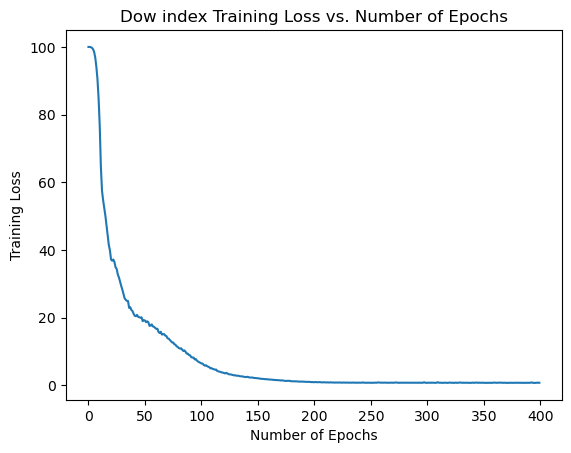

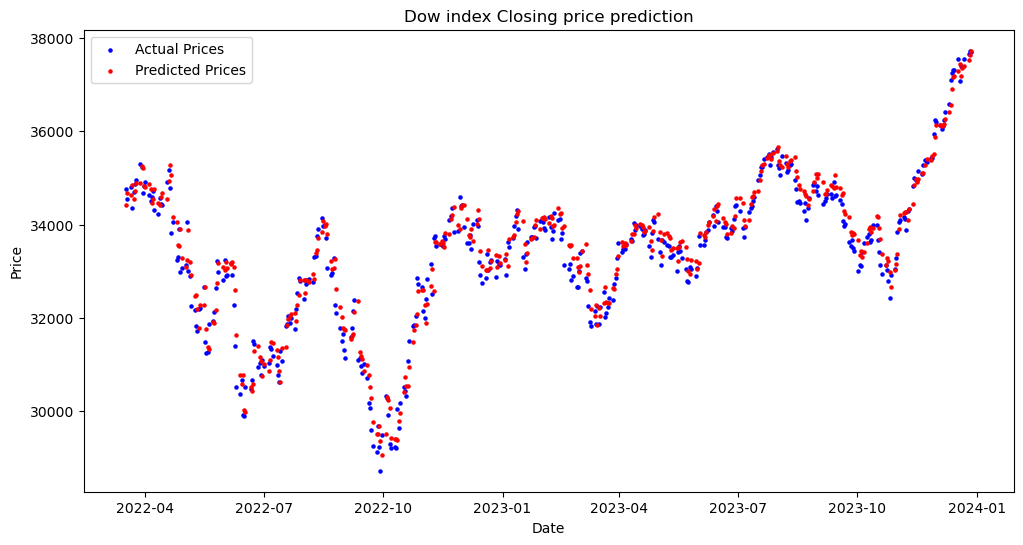

In [20]:
ANN_model_testing('Dow',history_dow,model_dow,X_test_dow,y_test_dow)

### S&P500 Index

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2378  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Validation Loss is: 1.12%


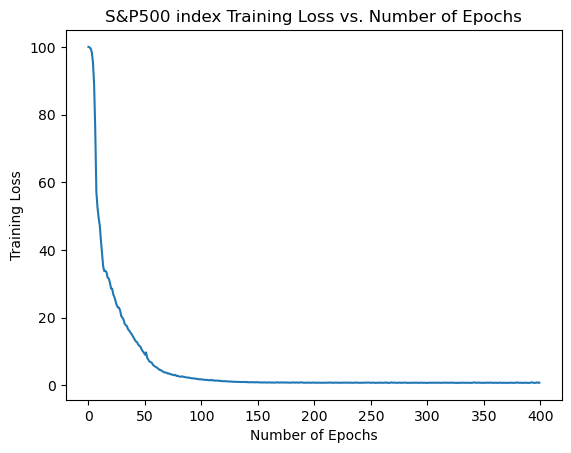

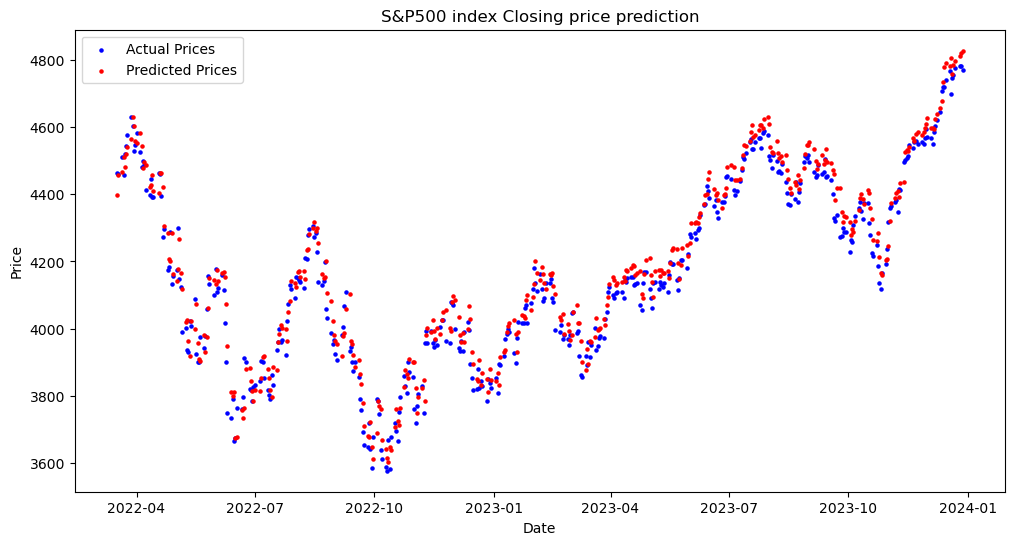

In [21]:
ANN_model_testing('S&P500',history_sp5,model_sp5,X_test_sp5,y_test_sp5)

### Nasdaq 100 Index

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 1.4962
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Validation Loss is: 1.21%


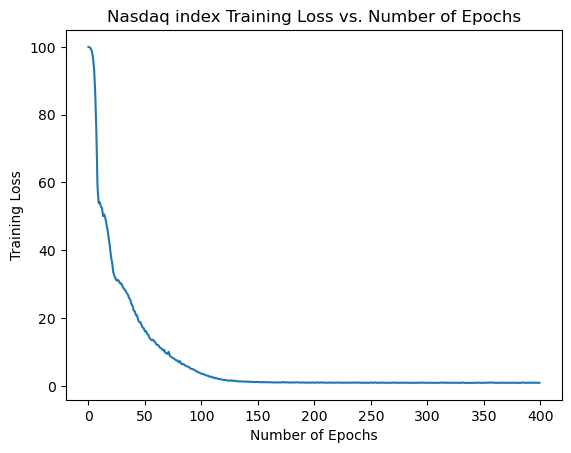

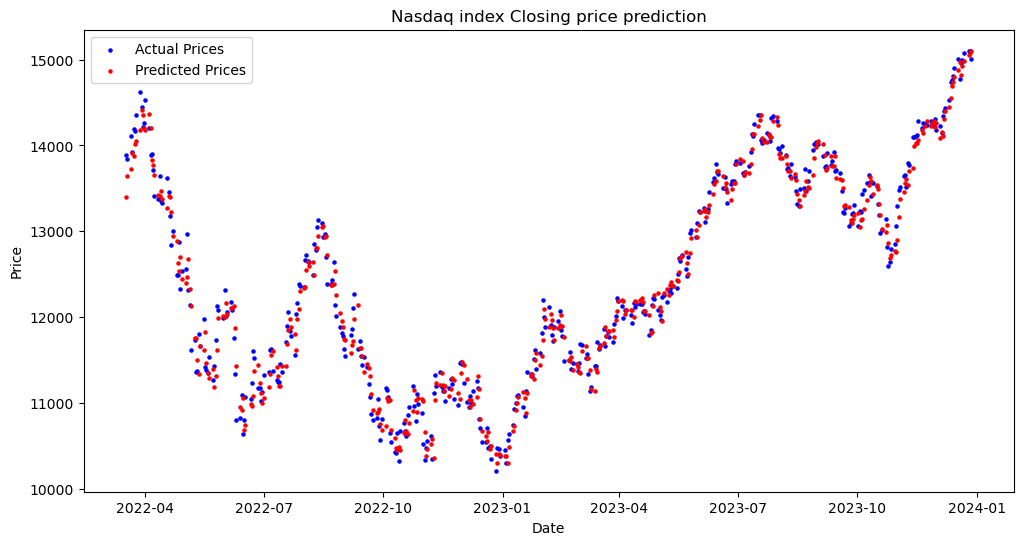

In [22]:
ANN_model_testing('Nasdaq',history_nasd,model_nasd,X_test_nasd,y_test_nasd)

### Result Analysis

**Observations** - We have tried different batch size and epochs. Choosing 400 epochs and 64 batch size work well in our case.  Training loss reduces rapidly in the start and then the model gets converged. Training errors are below 1% for all three models. We have tested these individual models on the testing data for each index. Below results section highlights the testing accuracy.

**Results** - The ANN model is able to successfully forecast the next day closing price of Dow, S&P 500 and Nasdaq index. We get 0.79% error for Dow index. S&P500 index forecast error is around 1% and for Nasdaq the error is 1.25%. Overall, on average 1% forecasting error is observed. Given the non-linearity in timeseries the model performance is superior.

We have also calculated the index volatility above. Results are as follows - 
 - Dow index volatility is: 18.10%
 - S&P500 index volatility is: 18.33%
 - Nasdaq index volatility is: 21.70%

The Nasdaq Composite and the S&P 500 cover more sectors and more stocks in their portfolio, while the Dow is a blue-chip index for 30 stocks. We could see that Nasdaq is slightly higher volatile compared to other two indicies. Given the volatility, model performance is very good for all three indices.

Below table shows the overall model summary and total numbers of parameters.

In [23]:
model_dow.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,525 (21.59 KB)

 Trainable params: 1,841 (7.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,684 (14.39 KB)

 ### Use of Genetic Algorithm to optimise ANN weights

First, we train the neural network having 2 hidden layers one neuron in output layer. The hidden layer has 20 and 10 neurons respectively. Here, we are using Relu activation function. The network weights are optimised using evolutionary genetic algorithm. Genetic algorithm has three important steps selection, mutation and crossover.

We are using steady state selection, adaptive mutation and two-point crossover techniques. We have tried other variables also but this combination works best.

In [25]:
# function takes two inputs features and target
def GANN_model(df):
    
    X = df.drop(['Adj Close','Index','Targetprice'], axis=1)
    y = df['Targetprice']

    # Scale the input features using MinMax scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
        
    # Data inputs
    data_inputs = X_test
    n_cols = data_inputs.shape[1]

    # Data outputs
    data_outputs = np.array(y_test)
    
    # Define the model using functional API
    # 2 Hidden layers
    tf.keras.backend.clear_session()
    input_layer  = tf.keras.layers.Input((n_cols,))
    dense_layer1 = tf.keras.layers.Dense(10, activation="relu")(input_layer)
    dense_layer1.trainable = True
    dense_layer2 = tf.keras.layers.Dense(5, activation="relu")(dense_layer1)
    dense_layer2.trainable = True
    output_layer = tf.keras.layers.Dense(1, activation="linear")(dense_layer2)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    
    # ANN model initialisation
    keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=20)
    
    #fitness function over the generation 
    def fitness_func(ga_instanse, solution, sol_idx):
        nonlocal data_inputs, data_outputs, keras_ga, model
        
        predictions = pygad.kerasga.predict(model=model,
                                            solution=solution,
                                            data=data_inputs,
                                            batch_size = 500)
        
        # MAPE (Mean Absolute Percentage Error
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        abs_error = mape(data_outputs, predictions).numpy() + 0.00000001
        solution_fitness = 100.0 / abs_error

        return solution_fitness

    def on_generation(ga_instance):
        print(f"Generation = {ga_instance.generations_completed}")
        print(f"Fitness    = {ga_instance.best_solution()[1]}")
    
    #prepare the genetic algorithm parameters
    num_generations =    200    # Number of generations.
    num_parents_mating = 2  # Number of solutions to be selected as parents in the mating pool.
    initial_population = keras_ga.population_weights # Initial population of network weights

    mutation_probability = [0.6, 0.4]
    parent_selection_type = "sss" # Type of parent selection. #sss
    crossover_type = "two_points" # Type of the crossover operator
    mutation_type = "adaptive"  # Type of the mutation operator
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents.

    ga_instance = pygad.GA(num_generations=num_generations, 
                           num_parents_mating=num_parents_mating, 
                           initial_population=initial_population,
                           fitness_func=fitness_func,
                           parent_selection_type=parent_selection_type,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_probability = mutation_probability,
                           keep_parents=keep_parents,
                           on_generation=on_generation)

    ga_instance.run()

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print(f"Fitness value of the best solution = {solution_fitness}")
    
    # predict the model output
    predictions = pygad.kerasga.predict(model=model,
                                        solution=solution,
                                        data=data_inputs)
    
    #calculate MAPE statistics
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    abs_error = mape(data_outputs, predictions).numpy()
    
    return ga_instance, abs_error, predictions


In [26]:
ga_instance_dow, ga_err_dow, ga_pred_dow = GANN_model(df = dow)

C:\Users\hjeen\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 1.0005507638893143
Generation = 2
Fitness    = 1.000965133365134
Generation = 3
Fitness    = 1.0016291603665926
Generation = 4
Fitness    = 1.0021381218921808
Generation = 5
Fitness    = 1.003226932231746
Generation = 6
Fitness    = 1.0048261121307314
Generation = 7
Fitness    = 1.0068699948163369
Generation = 8
Fitness    = 1.0116626162193274
Generation = 9
Fitness    = 1.016226344714968
Generation = 10
Fitness    = 1.0213729966301726
Generation = 11
Fitness    = 1.024615649814042
Generation = 12
Fitness    = 1.030430935463193
Generation = 13
Fitness    = 1.0363807828537932
Generation = 14
Fitness    = 1.0405287998795363
Generation = 15
Fitness    = 1.0589095166545712
Generation = 16
Fitness    = 1.0608469437892052
Generation = 17
Fitness    = 1.0750920707194942
Generation = 18
Fitness    = 1.0912496218998624
Generation = 19
Fitness    = 1.1135823967917564
Generation = 20
Fitness    = 1.1218238263228562
Generation = 21
Fitness    = 1.1469602297365276
Genera

Generation = 142
Fitness    = 119.96163020973374
Generation = 143
Fitness    = 119.96163020973374
Generation = 144
Fitness    = 119.96163020973374
Generation = 145
Fitness    = 119.96163020973374
Generation = 146
Fitness    = 119.96163020973374
Generation = 147
Fitness    = 119.96163020973374
Generation = 148
Fitness    = 121.61758951745935
Generation = 149
Fitness    = 121.61758951745935
Generation = 150
Fitness    = 121.61758951745935
Generation = 151
Fitness    = 121.61758951745935
Generation = 152
Fitness    = 121.61758951745935
Generation = 153
Fitness    = 121.61758951745935
Generation = 154
Fitness    = 121.61758951745935
Generation = 155
Fitness    = 121.61758951745935
Generation = 156
Fitness    = 121.61758951745935
Generation = 157
Fitness    = 121.61758951745935
Generation = 158
Fitness    = 121.61758951745935
Generation = 159
Fitness    = 121.61758951745935
Generation = 160
Fitness    = 121.61758951745935
Generation = 161
Fitness    = 121.61758951745935
Generation = 162
Fit

In [27]:
ga_instance_sp5, ga_err_sp5, ga_pred_sp5 = GANN_model(df = sp5)

C:\Users\hjeen\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 1.0021582735008876
Generation = 2
Fitness    = 1.0045139209068954
Generation = 3
Fitness    = 1.0125368174517408
Generation = 4
Fitness    = 1.0159911322983917
Generation = 5
Fitness    = 1.0268051835247518
Generation = 6
Fitness    = 1.048732219041381
Generation = 7
Fitness    = 1.0826548567303598
Generation = 8
Fitness    = 1.1169515756033948
Generation = 9
Fitness    = 1.181124322585198
Generation = 10
Fitness    = 1.2223579442912673
Generation = 11
Fitness    = 1.3062276217919235
Generation = 12
Fitness    = 1.4794327334042257
Generation = 13
Fitness    = 1.611469821103738
Generation = 14
Fitness    = 1.7303289142740548
Generation = 15
Fitness    = 1.862003191589766
Generation = 16
Fitness    = 2.1224524821227857
Generation = 17
Fitness    = 2.4325281597095705
Generation = 18
Fitness    = 3.066274569733516
Generation = 19
Fitness    = 4.182552030851505
Generation = 20
Fitness    = 7.273271580350662
Generation = 21
Fitness    = 16.37431737877857
Generatio

Generation = 175
Fitness    = 93.83775099788444
Generation = 176
Fitness    = 93.83775099788444
Generation = 177
Fitness    = 93.83775099788444
Generation = 178
Fitness    = 93.83775099788444
Generation = 179
Fitness    = 93.83775099788444
Generation = 180
Fitness    = 93.83775099788444
Generation = 181
Fitness    = 93.83775099788444
Generation = 182
Fitness    = 98.99982860336478
Generation = 183
Fitness    = 98.99982860336478
Generation = 184
Fitness    = 98.99982860336478
Generation = 185
Fitness    = 98.99982860336478
Generation = 186
Fitness    = 98.99982860336478
Generation = 187
Fitness    = 98.99982860336478
Generation = 188
Fitness    = 98.99982860336478
Generation = 189
Fitness    = 98.99982860336478
Generation = 190
Fitness    = 98.99982860336478
Generation = 191
Fitness    = 98.99982860336478
Generation = 192
Fitness    = 98.99982860336478
Generation = 193
Fitness    = 98.99982860336478
Generation = 194
Fitness    = 98.99982860336478
Generation = 195
Fitness    = 98.9998286

In [28]:
ga_instance_nasd, ga_err_nasd, ga_pred_nasd = GANN_model(df = nasdaq)

C:\Users\hjeen\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 1.0020594387701547
Generation = 2
Fitness    = 1.0038673615344922
Generation = 3
Fitness    = 1.00713590261996
Generation = 4
Fitness    = 1.0148183515775016
Generation = 5
Fitness    = 1.019628184736628
Generation = 6
Fitness    = 1.0273221832644794
Generation = 7
Fitness    = 1.033511861719008
Generation = 8
Fitness    = 1.0405502772246678
Generation = 9
Fitness    = 1.0536663886530648
Generation = 10
Fitness    = 1.0666151065453027
Generation = 11
Fitness    = 1.084888879721621
Generation = 12
Fitness    = 1.110766011650204
Generation = 13
Fitness    = 1.1167210902800988
Generation = 14
Fitness    = 1.142575204962364
Generation = 15
Fitness    = 1.166620858053672
Generation = 16
Fitness    = 1.2046465356505458
Generation = 17
Fitness    = 1.2488478321490193
Generation = 18
Fitness    = 1.3308074739996134
Generation = 19
Fitness    = 1.3982349671144363
Generation = 20
Fitness    = 1.4501895106771252
Generation = 21
Fitness    = 1.553270302589088
Generation

Generation = 176
Fitness    = 75.74751625169775
Generation = 177
Fitness    = 75.74751625169775
Generation = 178
Fitness    = 75.74751625169775
Generation = 179
Fitness    = 75.74751625169775
Generation = 180
Fitness    = 75.74751625169775
Generation = 181
Fitness    = 75.74751625169775
Generation = 182
Fitness    = 75.74751625169775
Generation = 183
Fitness    = 75.74751625169775
Generation = 184
Fitness    = 75.74751625169775
Generation = 185
Fitness    = 75.74751625169775
Generation = 186
Fitness    = 75.74751625169775
Generation = 187
Fitness    = 75.74751625169775
Generation = 188
Fitness    = 75.74751625169775
Generation = 189
Fitness    = 75.74751625169775
Generation = 190
Fitness    = 75.74751625169775
Generation = 191
Fitness    = 75.74751625169775
Generation = 192
Fitness    = 75.74751625169775
Generation = 193
Fitness    = 75.74751625169775
Generation = 194
Fitness    = 75.74751625169775
Generation = 195
Fitness    = 75.74751625169775
Generation = 196
Fitness    = 75.7475162

### Genetic algorithm model Testing

Here, we will test our genetic model. First chart shows the fitness improvement over generations. Then we print Model validation loss for each model. Lastly, we plot the actual vs predicted prices for each index.

In [29]:
# Test the ANN model.
def GA_model_testing(instance, index_name, err,  y_test, y_pred):
    regressorName = index_name + " index Iteration vs. Fitness"
    instance.plot_fitness(title="Genetic Algorithm - Iteration vs. Fitness", color = '#1f77b4')

    # Trim the validation loss to two decimal places
    trimmed_val_loss = "{:.2f}".format(err)

    print(f"Model Validation Loss is: {trimmed_val_loss}%")

    # plot the actual vs predicted time-series

    # x-axis for validation plot
    x_ax = list(y_test.index)
    regressorName = index_name + " index Closing price prediction"
    plt.figure(figsize=(12, 6))  # Wide figure
    plt.scatter(x_ax, y_test, label='Actual Prices',color='blue',s=5)
    plt.scatter(x_ax, y_pred, label='Predicted Prices',color='red',s=5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(regressorName)
    plt.legend()
    plt.show()
    
    return

### Dow Index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


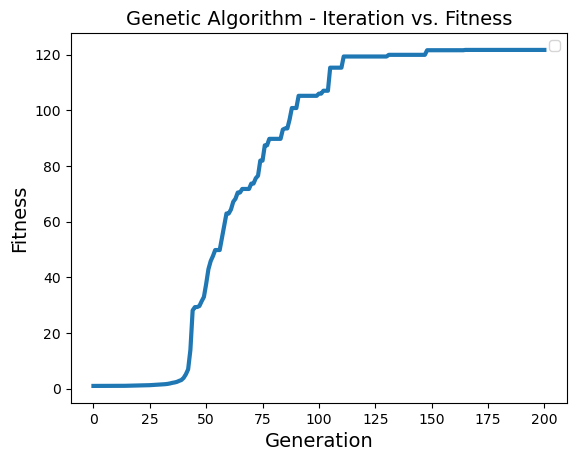

Model Validation Loss is: 0.82%


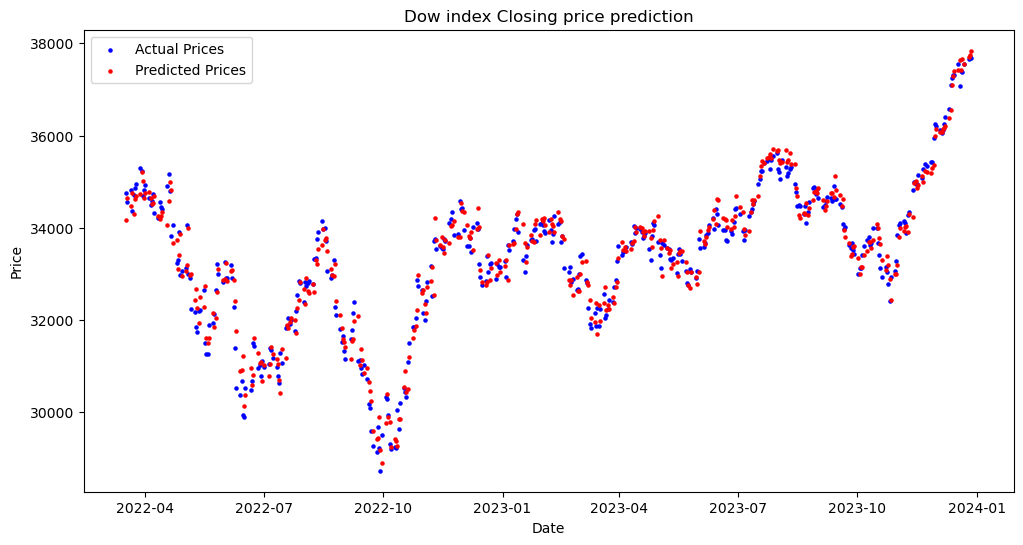

In [30]:
GA_model_testing(ga_instance_dow,'Dow',ga_err_dow,y_test_dow, ga_pred_dow)

### S&P500 Index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


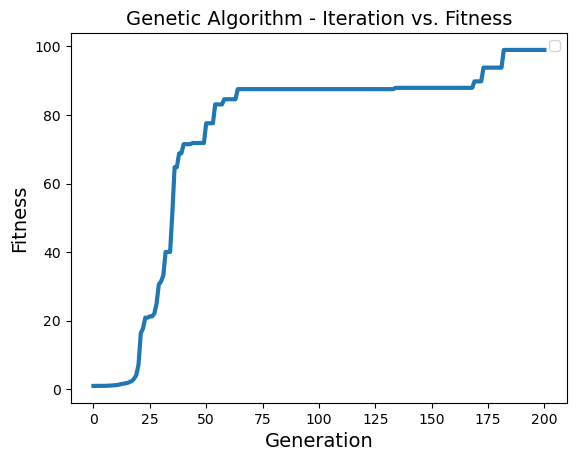

Model Validation Loss is: 1.01%


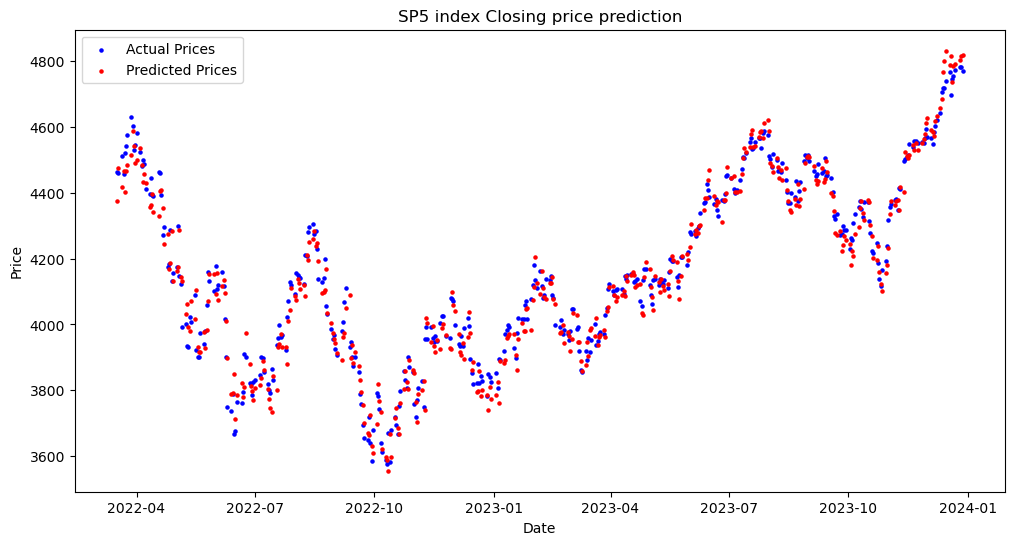

In [31]:
GA_model_testing(ga_instance_sp5,'SP5',ga_err_sp5,y_test_sp5, ga_pred_sp5)

### Nasdaq 100 Index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


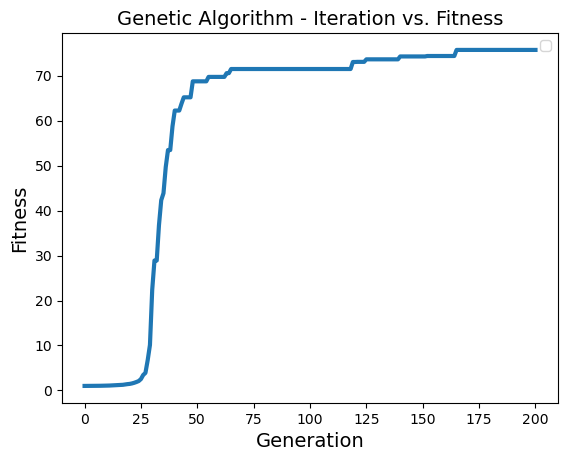

Model Validation Loss is: 1.32%


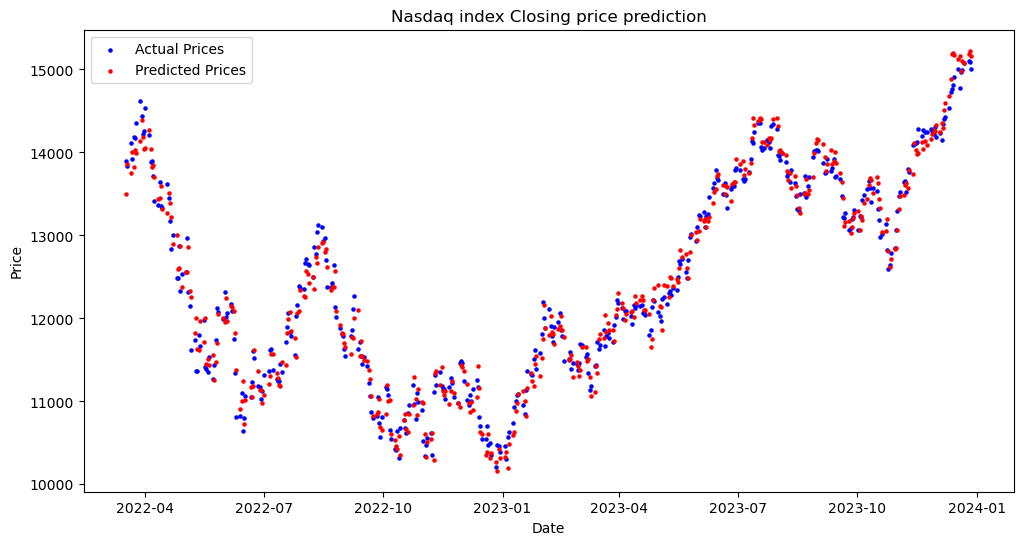

In [32]:
GA_model_testing(ga_instance_nasd,'Nasdaq',ga_err_nasd,y_test_nasd, ga_pred_nasd)

### Result Analysis

**Observations** - We have tried using different parent selection and crossover techniques.Choosing steady syate selection and two-point crossover works best in our case. Training errors are around 1% for all three models. We have tested these individual models on the testing data for each index. Below results section highlights the testing accuracy.

**Results** - The hybrid model is able to successfully forecast the next day closing price of Dow, S&P 500 and Nasdaq index. We get 0.82% error for Dow index. S&P500 index forecast error is around 1% and for Nasdaq the error is 1.32%. Overall, on average 1% forecasting error is observed. Given the non-linearity in timeseries the model performance is superior.

The Nasdaq Composite and the S&P 500 cover more sectors and more stocks in their portfolio, while the Dow is a blue-chip index for 30 stocks. We could see that Nasdaq is slightly higher volatile compared to other two indicies. Given the volatility, model performance is very good for all three indices.

In [3]:
print(datetime.datetime.now() )

2024-04-29 19:17:55.618586
